In [1]:
# install machine gnostic learning packages
# ! pip install machinegnostics # only if not installed

# Small data and regression

## Example 1


Cosine Function:
MSE (excluding outliers):
Regular Polynomial: 375.9472
Ridge Regression:   393.6559
Lasso Regression:   374.0560
Robust MG:          257.4340

Exponential Function:
MSE (excluding outliers):
Regular Polynomial: 516.3775
Ridge Regression:   505.5366
Lasso Regression:   508.2516
Robust MG:          5.5653

Sigmoid Function:
MSE (excluding outliers):
Regular Polynomial: 518.3422
Ridge Regression:   489.9117
Lasso Regression:   513.7563
Robust MG:          37.0000

Polynomial Function:
MSE (excluding outliers):
Regular Polynomial: 550.7217
Ridge Regression:   469.4905
Lasso Regression:   545.9007
Robust MG:          34.5630


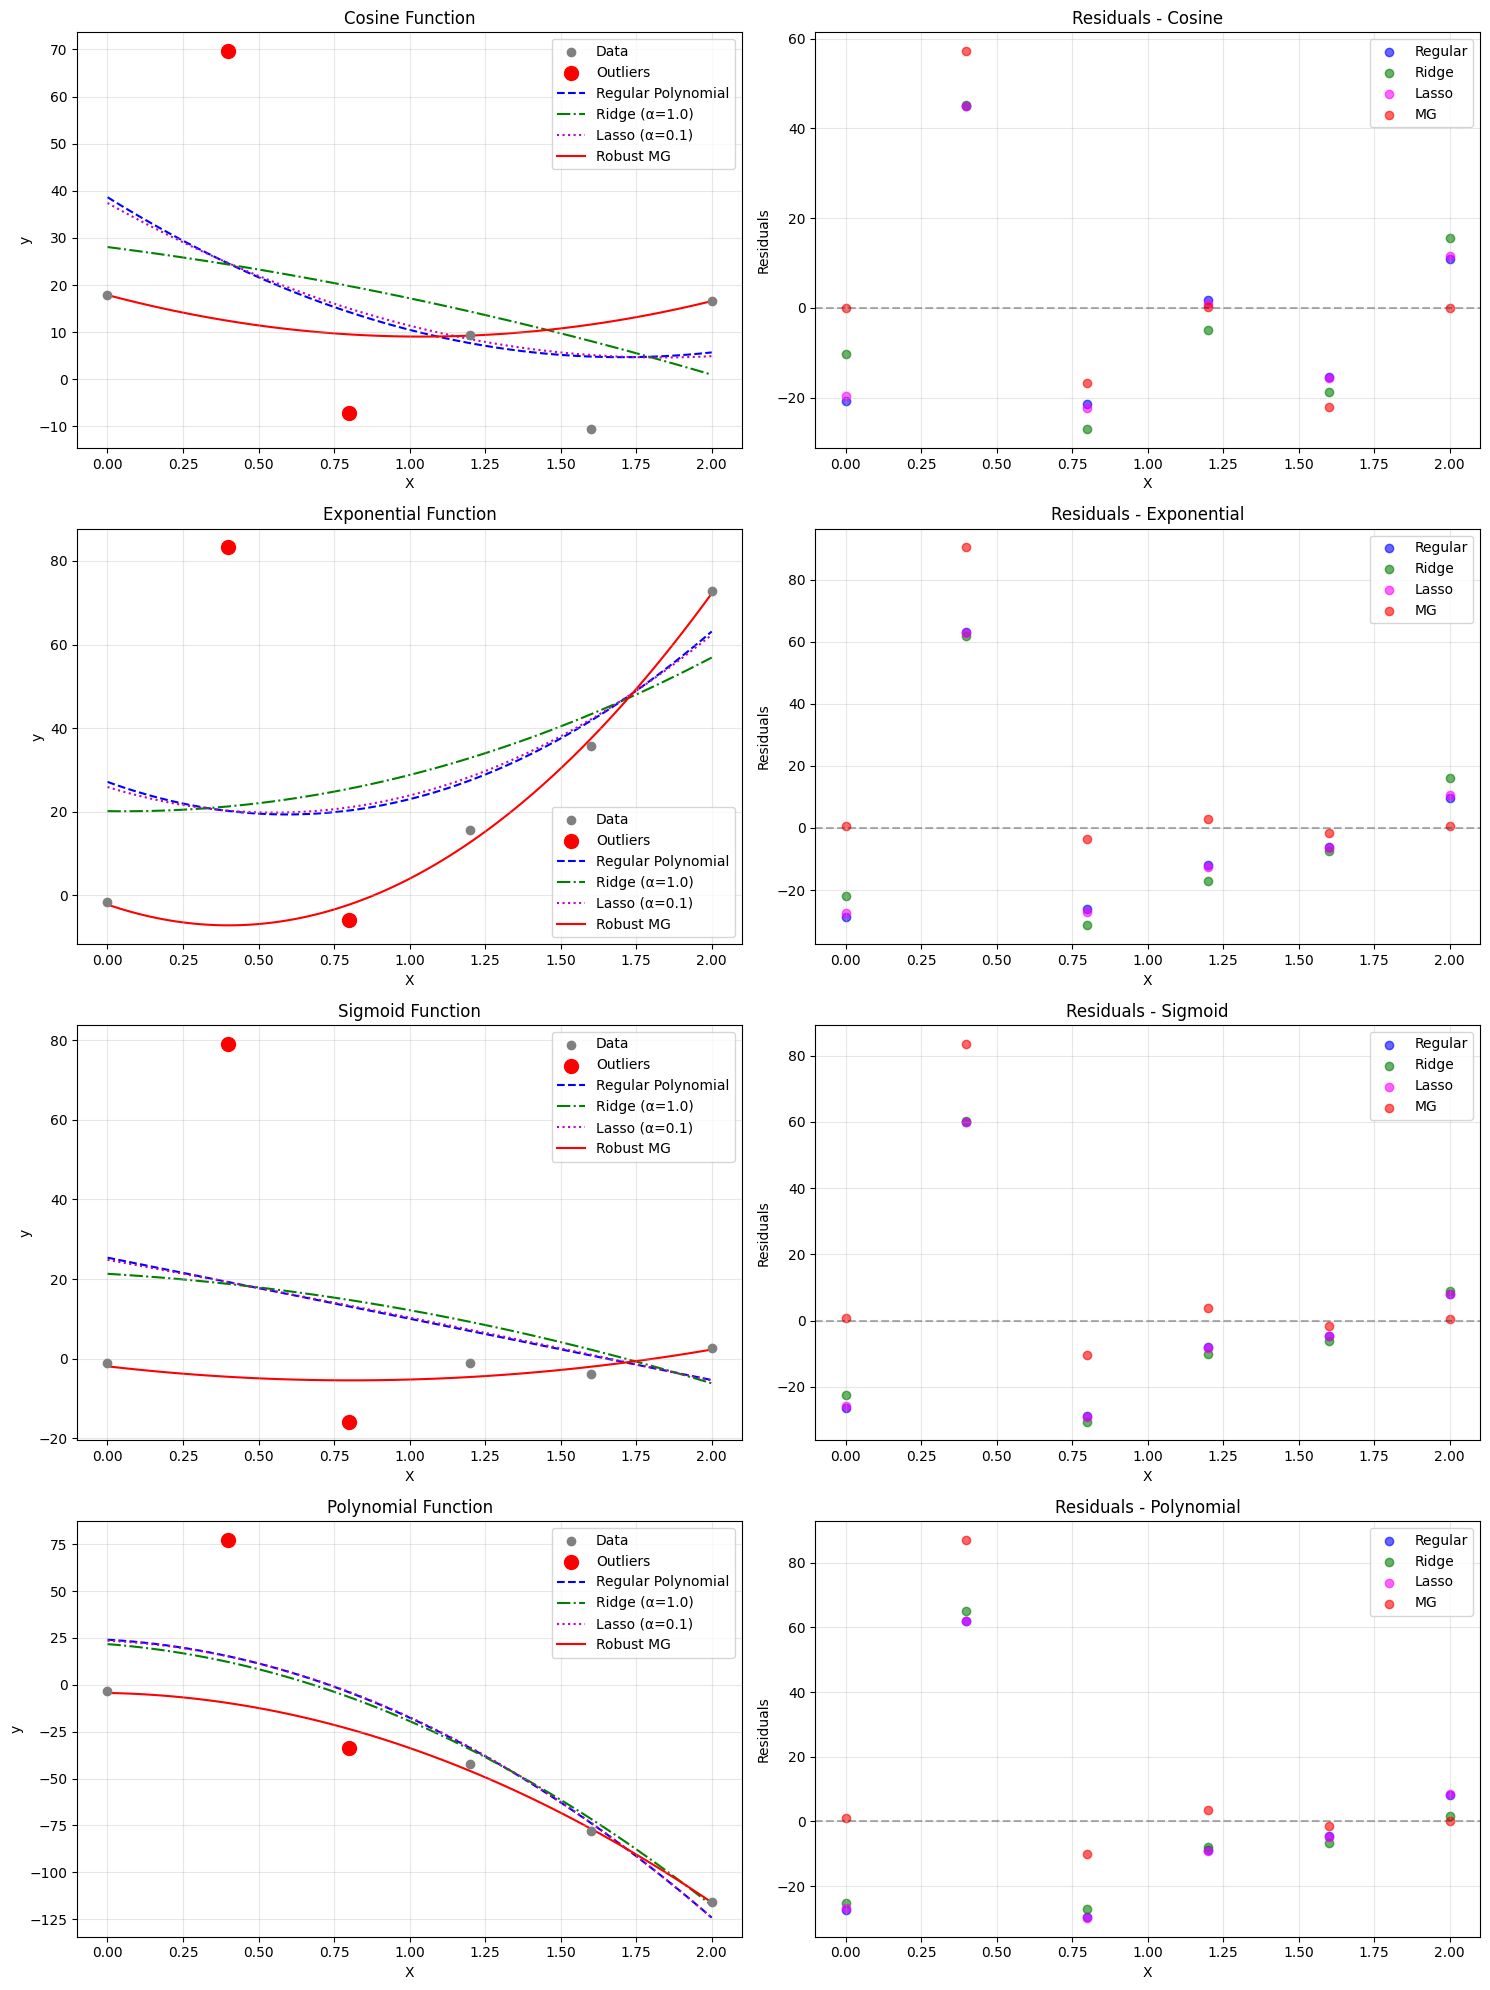

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from machinegnostics.models.regression import PolynomialRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Create multiple test functions
def generate_data(func_type, X, noise_level=1.8, outlier_positions=[1, 2], outlier_values=[80.0, -15.0]):
    if func_type == 'cosine':
        y = 15 * np.cos(2 * np.pi * X.ravel()) + 2
    elif func_type == 'exponential':
        y = 2.0 * np.exp(1.8 * X.ravel())
    elif func_type == 'sigmoid':
        y = 1.0 * (1 / (1 + np.exp(-5 * (X.ravel() - 1))))
    elif func_type == 'polynomial':
        y = 0.05 * X.ravel()**3 - 30 * X.ravel()**2 + 1
    
    y = y + np.random.normal(0, noise_level, len(X))
    y[outlier_positions] += outlier_values
    return y

# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

# Set regularization parameters
alpha_ridge = 1.0
alpha_lasso = 0.1

for i, func in enumerate(functions):
    # Generate data - changed to 5 points
    X = np.linspace(0, 2, 6).reshape(-1, 1)  # 5 points total
    y = generate_data(func, X)
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    
    # Fit models
    degree = 2  # Reduced degree due to fewer points
    # Regular polynomial regression
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    # Ridge regression
    ridge_reg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_ridge))
    ridge_reg.fit(X, y)
    y_pred_ridge = ridge_reg.predict(X)
    y_pred_ridge_test = ridge_reg.predict(X_test)
    
    # Lasso regression
    lasso_reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_lasso))
    lasso_reg.fit(X, y)
    y_pred_lasso = lasso_reg.predict(X)
    y_pred_lasso_test = lasso_reg.predict(X_test)
    
    # Machine Gnostics regression
    mg_model = PolynomialRegressor(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_ridge = y - y_pred_ridge
    residuals_lasso = y - y_pred_lasso
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2)
    # Highlight outliers
    axes[i,0].scatter(X[[1, 2]], y[[1, 2]], color='red', s=100, label='Outliers', zorder=3)

    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_ridge_test, 'g-.', label=f'Ridge (α={alpha_ridge})', zorder=1)
    axes[i,0].plot(X_test, y_pred_lasso_test, 'm:', label=f'Lasso (α={alpha_lasso})', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular', alpha=0.6)
    axes[i,1].scatter(X, residuals_ridge, color='green', label='Ridge', alpha=0.6)
    axes[i,1].scatter(X, residuals_lasso, color='magenta', label='Lasso', alpha=0.6)
    axes[i,1].scatter(X, residuals_robust, color='red', label='MG', alpha=0.6)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Calculate metrics excluding outliers
    good_indices = [0, 2, 4]  # Indices of non-outlier points
    mse_regular = np.mean((y_pred_regular[good_indices] - y[good_indices])**2)
    mse_ridge = np.mean((y_pred_ridge[good_indices] - y[good_indices])**2)
    mse_lasso = np.mean((y_pred_lasso[good_indices] - y[good_indices])**2)
    mse_robust = np.mean((y_pred_robust[good_indices] - y[good_indices])**2)
    
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Ridge Regression:   {mse_ridge:.4f}")
    print(f"Lasso Regression:   {mse_lasso:.4f}")
    print(f"Robust MG:          {mse_robust:.4f}")

plt.tight_layout()
plt.show()

## Example 2


Cosine Function:
MSE (excluding outliers):
Regular Polynomial: 445.5874
Robust MG Regression: 548.8367

Exponential Function:
MSE (excluding outliers):
Regular Polynomial: 523.2084
Robust MG Regression: 751.0074

Sigmoid Function:
MSE (excluding outliers):
Regular Polynomial: 522.8897
Robust MG Regression: 804.6033

Polynomial Function:
MSE (excluding outliers):
Regular Polynomial: 503.3894
Robust MG Regression: 784.5227


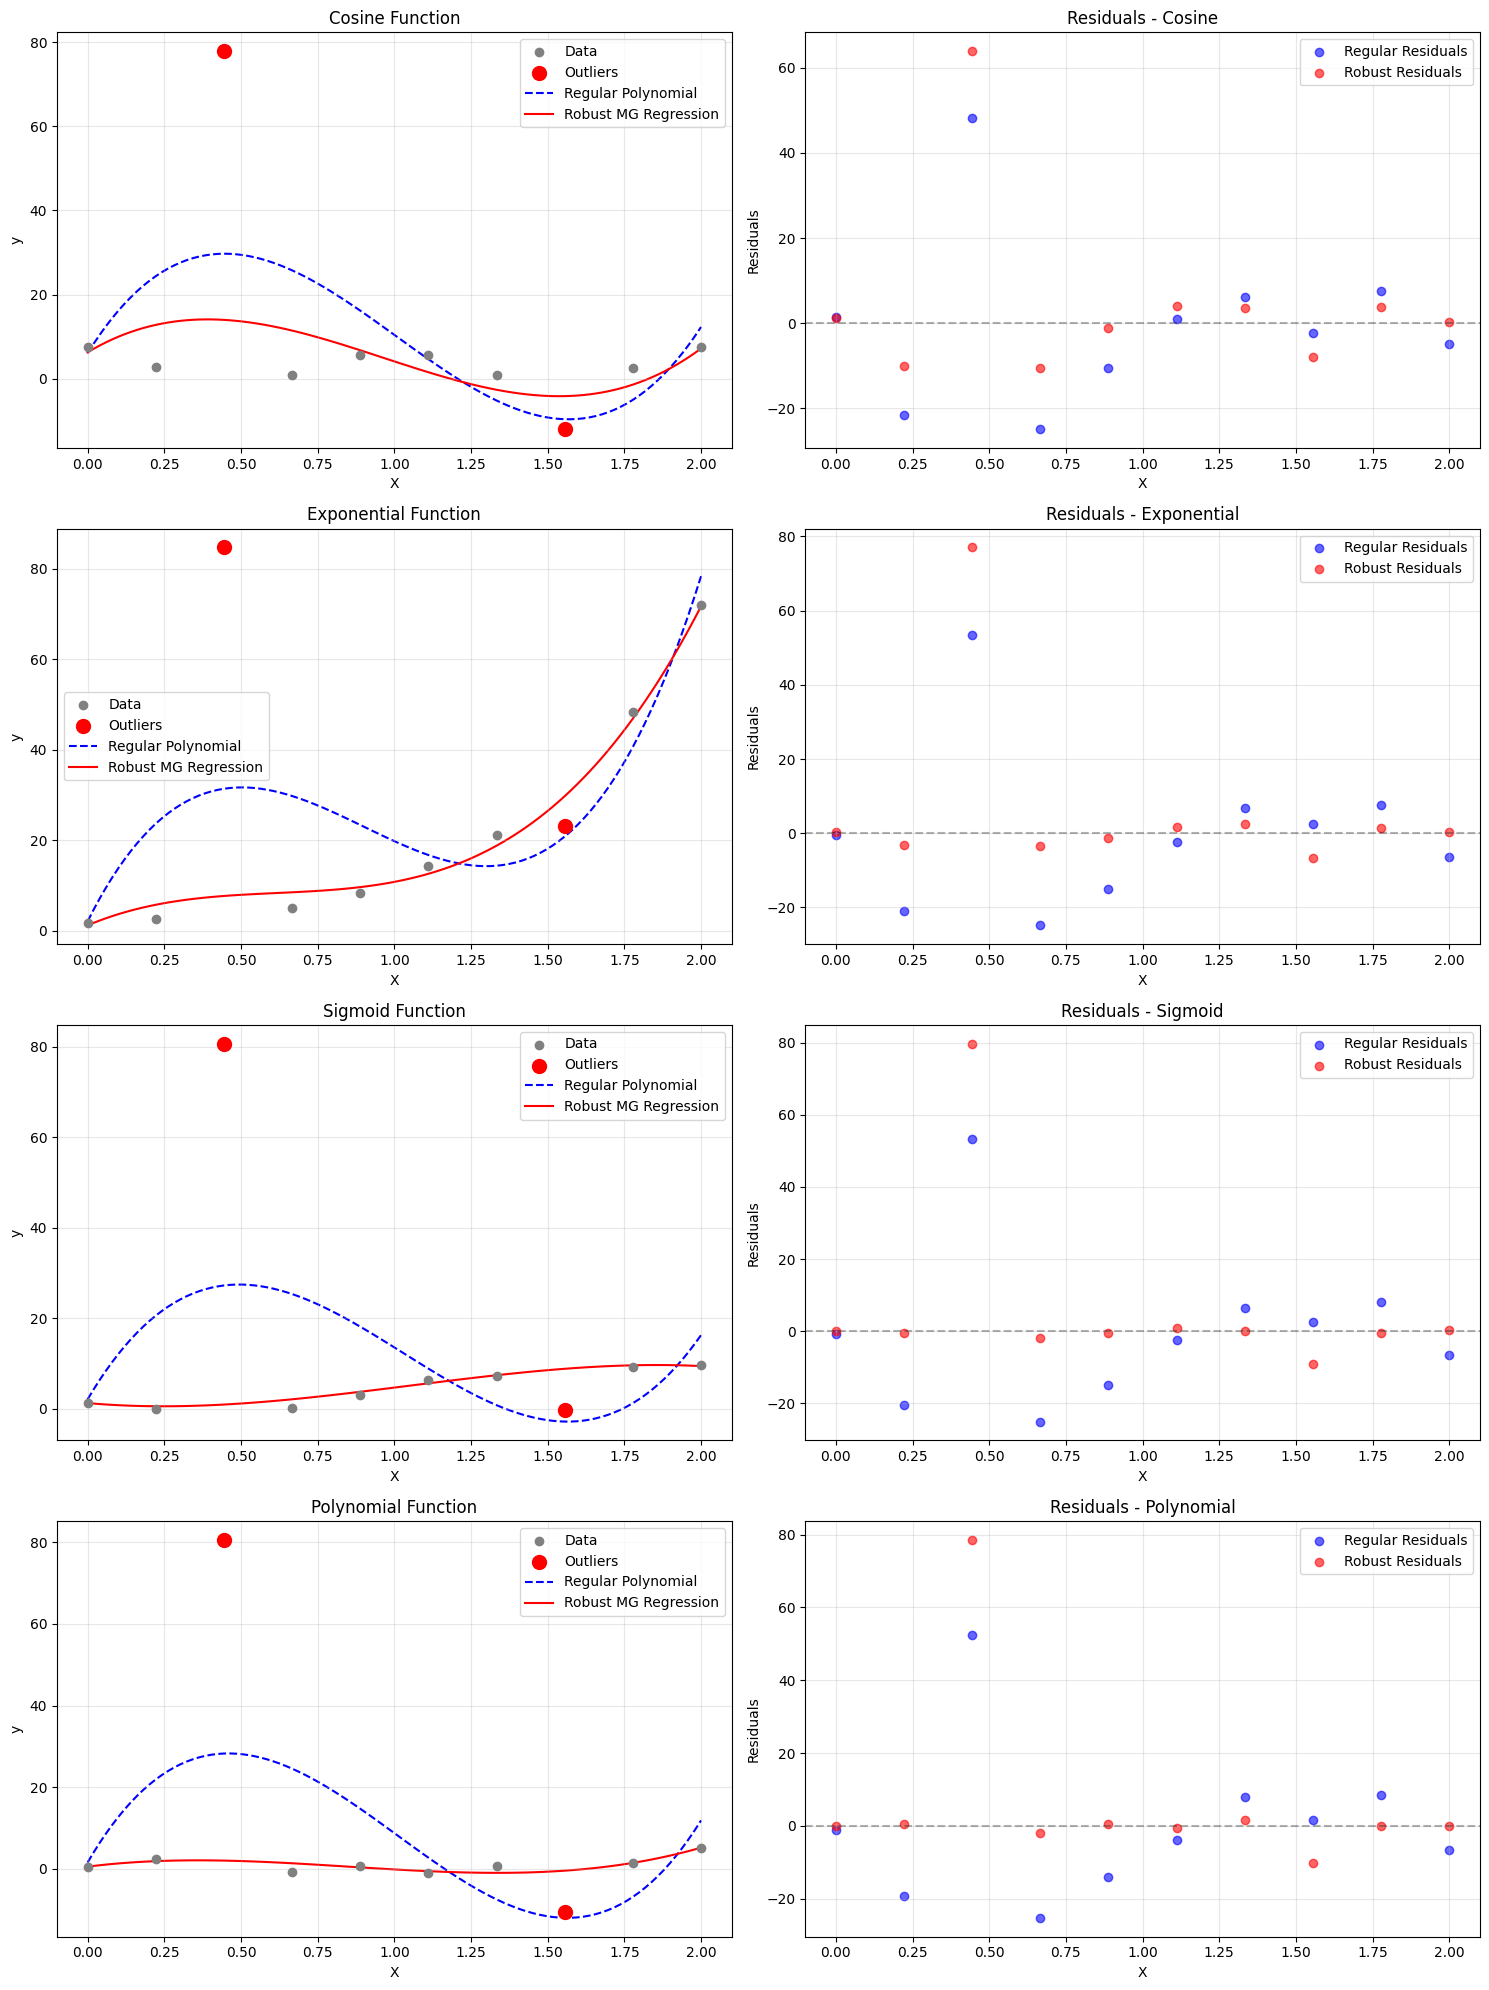

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)
outlier_positions=[2, 7]

# Create multiple test functions
def generate_data(func_type, X, noise_level=0.9, outlier_positions=outlier_positions, outlier_values=[80.0, -10.0]):
    if func_type == 'cosine':
        y = 5 * np.cos(2 * np.pi * X.ravel()) + 2
    elif func_type == 'exponential':
        y = 2.0 * np.exp(1.8 * X.ravel())
    elif func_type == 'sigmoid':
        y = 10.0 * (1 / (1 + np.exp(-5 * (X.ravel() - 1))))
    elif func_type == 'polynomial':
        y = 2 * X.ravel()**3 - 3 * X.ravel()**2 + 1
    
    # Add noise
    y = y + np.random.normal(0, noise_level, len(X))
    
    # Add outliers
    y[outlier_positions] += outlier_values
    return y

# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

for i, func in enumerate(functions):
    # Generate data
    X = np.linspace(0, 2, 10).reshape(-1, 1)
    y = generate_data(func, X)
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    
    # Fit models
    degree = 3  # Increased degree for more complex functions
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    mg_model = PolynomialRegressor(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2)
    # Highlight outliers
    axes[i,0].scatter(X[outlier_positions], y[outlier_positions], color='red', s=100, label='Outliers', zorder=3)
    # axes[i,0].scatter(X[8:], y[2,8], color='red', s=100, label='Outliers', zorder=3)
    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG Regression', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular Residuals', alpha=0.6)
    axes[i,1].scatter(X, residuals_robust, color='red', label='Robust Residuals', alpha=0.6)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Print metrics
    mse_regular = np.mean((y_pred_regular[:-2] - y[:-2])**2)
    mse_robust = np.mean((y_pred_robust[:-2] - y[:-2])**2)
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Robust MG Regression: {mse_robust:.4f}")

plt.tight_layout()
plt.show()

In [4]:
from machinegnostics.models import CrossValidator
from machinegnostics.metrics import mean_squared_error

cv = CrossValidator(model=mg_model, X=X, y=y, k=5, random_seed=42)

cv.evaluate(mean_squared_error)

[65.02197077211763,
 118.64144768568106,
 5982.035194313063,
 15.168517813554473,
 25.46704044350545]